In [33]:
import glob
import pandas as pd
import seaborn as sns

# Connected regions analysis

In [129]:
from nilearn.image import threshold_img

#group average of 2B > (1B+0B)
threshold_percentile_img = threshold_img('level3/A/noGSR/Cope3_Level3/stats_dir/stats/tstat1.nii.gz', threshold=2.33, copy=False)

#group average of 2B > 0B
threshold_percentile_img2 = threshold_img('level3/noGSR/A/cope/6/Cope3_Level3/stats_dir/stats/tstat1.nii.gz', threshold=2.33, copy=False)

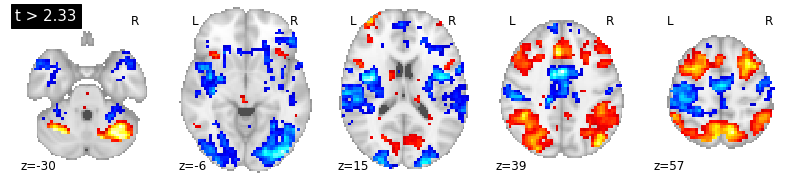

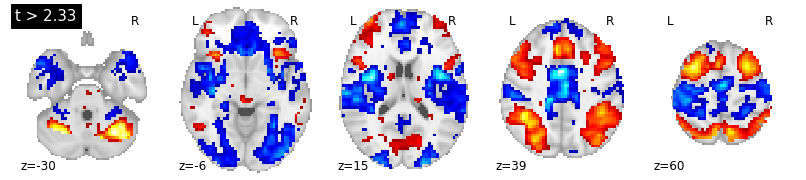

In [130]:
from nilearn import plotting

# Showing percentile threshold image
plotting.plot_stat_map(threshold_percentile_img, display_mode='z', cut_coords=5,
                       title='t > 2.33', colorbar=False)

#group average of 2B > 0B
plotting.plot_stat_map(threshold_percentile_img2, display_mode='z', cut_coords=5,
                       title='t > 2.33', colorbar=False)

/home1/06028/tbweng/.local/lib/python3.7/site-packages/nilearn/plotting/displays.py:99: UserWarning: No contour levels were found within the data range.
  **kwargs)


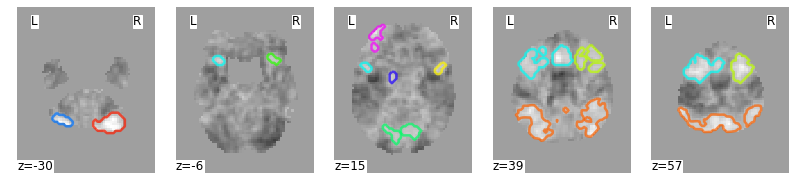

In [131]:
from nilearn.regions import connected_regions

regions_percentile_img, index = connected_regions(threshold_percentile_img, min_region_size=500, extract_type='connected_components')

plotting.plot_prob_atlas(regions_percentile_img, bg_img='level3/A/noGSR/Cope3_Level3/stats_dir/stats/tstat1.nii.gz',
                         view_type='contours', display_mode='z',
                         cut_coords=5)

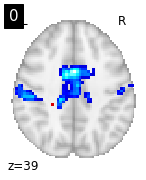

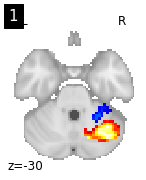

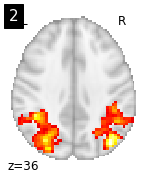

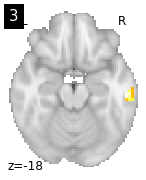

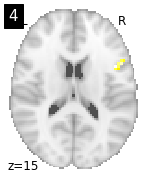

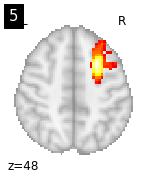

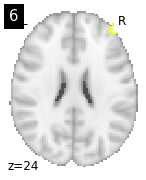

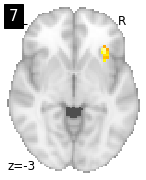

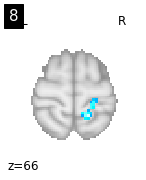

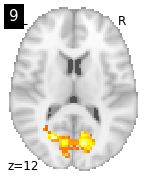

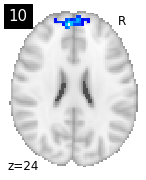

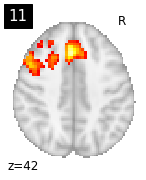

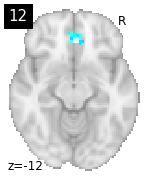

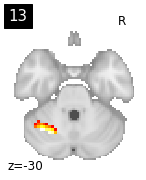

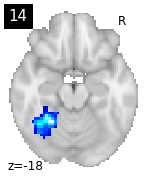

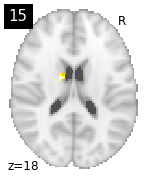

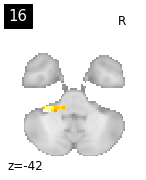

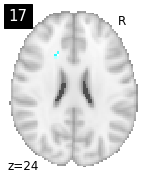

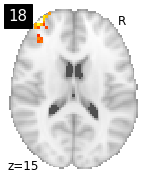

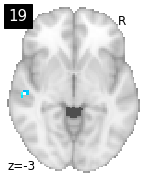

In [133]:
# from nilearn import image

# plotting.plot_stat_map(image.index_img(regions_percentile_img, 4), display_mode='z',
#                            title="Blob of network3", colorbar=False)

from nilearn.image import iter_img
from nilearn.plotting import plot_stat_map, show

for i, cur_img in enumerate(iter_img(regions_percentile_img)):
    plot_stat_map(cur_img, display_mode="z", title="%d" % i,
                  cut_coords=1, colorbar=False)
    
    # save binarized file
    mask = math_img('img > 0', img=cur_img)
    mask.to_filename('connected_regions_' + str(i).zfill(4) + '_bin.nii.gz')
    
    cur_img.to_filename('connected_regions_' + str(i).zfill(4) + '.nii.gz')

# Extract time series from ROI

In [3]:
# list of preprocessed scans 
preproc_list = sorted(glob.glob('/scratch/05201/bhickson/preprocdata/sub-*/output/pipeline_analysis_nuisance/sub-*_ses-*/functional_to_standard/_scan_nback_run-0*/_selector_CSF-2mmE-M_aC-WM-2mm-DPC5_M-SDB_P-2/residuals_antswarp.nii.gz'))


In [48]:
import numpy as np
# ROI Coordinates Haley et al 2007
# [
# (1, -33, 8, 58 )
# (2, -4, 24, 43 )
# (3, 40, -62, 59 )
# (4, -50, -51, 49 )
# (5, -45, 48, 8 )
# (6, 36, 52, 9 )
# (7, 35, 10, 56 )
# (8, 51, 16, -2 )
# ]

a = np.array([1,2,3,4,5,6,7,8], dtype=np.int)
b = np.array([-33,-4,40,-50,-45,36,35,51], dtype=np.int)
c = np.array([8,24,-62,-51,48,52,10,16], dtype=np.int)
d = np.array([58,43,59,49,8,9,56,-2], dtype=np.int)

rois = np.rec.fromarrays([a, b, c, d], names=['roi', 'x', 'y', 'z'])
coords = np.vstack((rois['x'], rois['y'], rois['z'])).T

In [100]:
# make spherical ROIs (for featquery)
for i, j in enumerate(coords):
    !singularity exec fcpindi_c-pac_latest-1.5.0.sif bash makeROI.sh {str(j)[1:-1]} mm 14 sphere "haley_roi_{str(i).zfill(4)}"

-33 8 58 mm 14 sphere haley_roi_0000
perl: warning: Setting locale failed.
perl: warning: Please check that your locale settings:
	LANGUAGE = (unset),
	LC_ALL = (unset),
	LANG = "en_US.UTF-8"
    are supported and installed on your system.
perl: warning: Falling back to the standard locale ("C").
The voxel coordinates are: 41 44.6667 43.3333
Finished!
-4 24 43 mm 14 sphere haley_roi_0001
perl: warning: Setting locale failed.
perl: warning: Please check that your locale settings:
	LANGUAGE = (unset),
	LC_ALL = (unset),
	LANG = "en_US.UTF-8"
    are supported and installed on your system.
perl: warning: Falling back to the standard locale ("C").
The voxel coordinates are: 31.3333 50 38.3333
Finished!
40 -62 59 mm 14 sphere haley_roi_0002
perl: warning: Setting locale failed.
perl: warning: Please check that your locale settings:
	LANGUAGE = (unset),
	LC_ALL = (unset),
	LANG = "en_US.UTF-8"
    are supported and installed on your system.
perl: warning: Falling back to the standard locale 

In [ ]:
from nilearn import input_data

masker = input_data.NiftiSpheresMasker(
    coords, radius=5,
    detrend=False, standardize=False,
    t_r=3,
    memory='nilearn_cache', memory_level=1, verbose=0)



In [ ]:
# extract time series

pooled_subjects = []

# parallel code
from joblib import Parallel, delayed
    
def extract_ts(func_file):
    time_series = masker.fit_transform(func_file)
    pooled_subjects.append(time_series)
    return time_series

pooled_subjects = Parallel(n_jobs=-1)(delayed(extract_ts)(func_file) for func_file in preproc_list)

print("The length of pooled_subjects list is: ", len(pooled_subjects))

In [125]:
# Save individual timeseries for each subject, for each ROI

for i in range(len(pooled_subjects)):
    
    # index the func_file name for the subject number
    func_file = preproc_list[i]
    sub='sub-' + str(func_file.split('/')[5].split('-')[1])
    ses='_ses-' + func_file.split('/')[8].split('_')[1].split('-')[1]
    run='_run-' + func_file.split('/')[10].split('_')[3].split('-')[1]
    
    for j in range(pooled_subjects[i].shape[1]):
    
        path = os.path.join('timeseries',sub)
        os.makedirs(path, exist_ok=True)
        filename = sub + ses + run + '_haley_roi_' + str(j) + '_ts.txt'

        np.savetxt(os.path.join('timeseries', sub, filename), pooled_subjects[i][:,j], fmt = '%.5f')

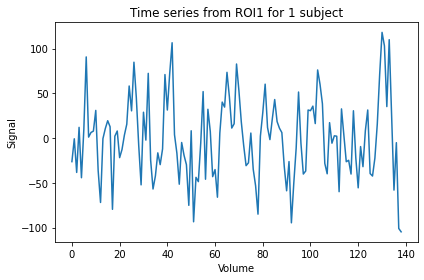

In [104]:
import matplotlib.pyplot as plt
plt.plot(pooled_subjects[0][:,1])
plt.title('Time series from ROI1 for 1 subject')
plt.xlabel('Volume')
plt.ylabel('Signal')
plt.tight_layout()

In [6]:
# rerun timeseries extraction

preproc_list = ['/scratch/05201/bhickson/preprocdata/sub-2071/output/pipeline_analysis_nuisance/sub-2071_ses-A/functional_to_standard/_scan_nback_run-02/_selector_CSF-2mmE-M_aC-WM-2mm-DPC5_M-SDB_P-2/residuals_antswarp.nii.gz']

# preproc_list = [
#     '/scratch/05201/bhickson/preprocdata/sub-9077/output/pipeline_analysis_nuisance/sub-9077_ses-B/functional_to_standard/_scan_nback_run-02/_selector_CSF-2mmE-M_aC-WM-2mm-DPC5_M-SDB_P-2/residuals_antswarp.nii.gz',
#     '/scratch/05201/bhickson/preprocdata/sub-2071/output/pipeline_analysis_nuisance/sub-2071_ses-A/functional_to_standard/_scan_nback_run-02/_selector_CSF-2mmE-M_aC-WM-2mm-DPC5_M-SDB_P-2/residuals_antswarp.nii.gz',
#     '/scratch/05201/bhickson/preprocdata/sub-9111/output/pipeline_analysis_nuisance/sub-9111_ses-A/functional_to_standard/_scan_nback_run-02/_selector_CSF-2mmE-M_aC-WM-2mm-DPC5_M-SDB_P-2/residuals_antswarp.nii.gz'
# ]


In [127]:
! singularity exec fcpindi_c-pac_latest-1.5.0.sif fslhd /scratch/05201/bhickson/preprocdata/sub-9111/output/pipeline_analysis_nuisance/sub-9111_ses-A/functional_to_standard/_scan_nback_run-02/_selector_CSF-2mmE-M_aC-WM-2mm-DPC5_M-SDB_P-2/residuals_antswarp.nii.gz


ERROR: Could not open file


In [7]:
# extract ts for connected regions ROIs

for func_file in preproc_list:
    for i in ['5', '6', '11', '18']:
        sub='sub-' + str(func_file.split('/')[5].split('-')[1])
        ses='_ses-' + func_file.split('/')[8].split('_')[1].split('-')[1]
        run='_run-' + func_file.split('/')[10].split('_')[3].split('-')[1]
        ts_filename = sub + ses + str(run) + '_connected_regions_' + str(i).zfill(4) + '_ts.txt'
        mask = '/scratch/05201/bhickson/preprocdata/connected_regions_' + str(i).zfill(4) + '_bin.nii.gz'

        !singularity exec fcpindi_c-pac_latest-1.5.0.sif \
            fslmeants \
                -i "{func_file}" \
                -o /scratch/05201/bhickson/preprocdata/timeseries/{sub}/{ts_filename} \
                -m {mask}

        
        

## PPI fsf files

In [49]:
filtered_func_data = sorted(glob.glob('/scratch/05201/bhickson/preprocdata/feat_dir/noGSR/run-*/ses-_*_sub-*_task-nback/run0.feat/filtered_func_data.nii.gz'))

In [73]:
len(filtered_func_data)

316

In [ ]:
# create scan specific fsf file

for func_file in filtered_func_data:
    i=5
    sub= func_file.split('/')[8].split('_')[2]
    ses='_ses-' + func_file.split('/')[8].split('_')[1]
    run= '_' + func_file.split('/')[7]
    ts_filename = sub + ses + str(run) + '_connected_regions_' + str(i).zfill(4) + '_ts.txt'

        
    # Read in the file
    with open('/scratch/05201/bhickson/preprocdata/design_ppi_template.fsf', 'r') as file :
        filedata = file.read()

    # Replace the target string
        filedata = filedata.replace('PREPROCDATA', func_file)
        filedata = filedata.replace('MEANTS', '/scratch/05201/bhickson/preprocdata/timeseries/' + sub + '/' + ts_filename)
        filedata = filedata.replace('OUTDIR', 'connected_regions_' + str(i).zfill(4) + '/' + sub + ses + str(run))

        fout_name = 'ppi/connected_regions_' + str(i).zfill(4) + '/' + sub + ses + str(run) + '_design.fsf'
        !mkdir -p ppi/connected_regions_{str(i).zfill(4)}
    # Write the file out again
    with open(fout_name, 'w') as file:
      file.write(filedata)

In [86]:
! cat $HOME/run_feat.sh

#!/usr/bin/env bash

#SBATCH -p itar
#SBATCH -t 5:00:00
#SBATCH -A LLLT

PARTICIPANTS=( sub-2006 )

TODO="$1"
case $TODO in

  list)
    printf '%s\n' "${PARTICIPANTS[@]}"
    ;;

  run)
    PARTICIPANT_LABEL="${2}"
    if [ -z "${PARTICIPANT_LABEL}" ]
    then
      echo "Unknown item"
      exit 1
    fi
    if [[ ! " ${PARTICIPANTS[@]} " =~ " ${PARTICIPANT_LABEL} " ]]; then
      echo "Unknown item on list"
      exit 1
    fi

    singularity exec /scratch/05201/bhickson/fsl-6.0.3.simg bash /scratch/05201/bhickson/preprocdata/feat_parallel.sh;;

  *)
    echo "Unknown command"
    exit 1
    ;;
esac


In [84]:
# run feat in parallel on a single node
! cd $HOME; batcher run_feat run_feat.sh

/opt/tacc_mounts/home1/06028/tbweng/batcher_dir/batcher-Zz6S5TnIPZ
2944564


In [101]:
# find errors
! for j in `find /scratch/05201/bhickson/preprocdata/ppi/connected_regions_0005/ -maxdepth 1 -type d -name '*.feat'`; do if [ ! -e ${j}/thresh_zstat3.nii.gz ]; then echo $j; fi; done


/scratch/05201/bhickson/preprocdata/ppi/connected_regions_0005/sub-9077_ses-B_run-02.feat
/scratch/05201/bhickson/preprocdata/ppi/connected_regions_0005/sub-2071_ses-A_run-02.feat
/scratch/05201/bhickson/preprocdata/ppi/connected_regions_0005/sub-9111_ses-A_run-02.feat


In [105]:
! cat /scratch/05201/bhickson/preprocdata/ppi/connected_regions_0005/sub-9111_ses-A_run-02.feat/logs/feat1


/bin/cp /scratch/05201/bhickson/preprocdata/ppi/connected_regions_0005/sub-9111_ses-A_run-02_design.fsf design.fsf

/usr/share/fsl/6.0/bin/feat_model design
Can't open /scratch/05201/bhickson/preprocdata/timeseries/sub-9111/sub-9111_ses-A_run-02_connected_regions_0005_ts.txt for reading

FATAL ERROR ENCOUNTERED:
COMMAND:
/usr/share/fsl/6.0/bin/feat_model design
ERROR MESSAGE:
child process exited abnormally
END OF ERROR MESSAGE


In [137]:
! sed -e 's/sub/sub-2071_ses-A_run-02/g' feat_parallel.sh > feat_rerun.sh
! cat feat_rerun.sh

source $FSLDIR/etc/fslconf/fsl.sh
find /scratch/05201/bhickson/preprocdata/ppi/connected_regions_0005 -maxdepth 1 -name "sub-2071_ses-A_run-02*fsf" | xargs -P 16 -t -n 1 feat



In [5]:
# rerun feat for sub-2071_ses-A_run-02
! rm -r /scratch/05201/bhickson/preprocdata/ppi/connected_regions_0005/sub-9111_ses-A_run-02.feat
! singularity exec ../fsl-6.0.3.simg bash feat_rerun.sh

feat /scratch/05201/bhickson/preprocdata/ppi/connected_regions_0005/sub-2071_ses-A_run-02_design.fsf 
child process exited abnormally
    while executing
"fsl:exec "${FSLDIR}/bin/feat_model design" $fmri(featModelOpts) -N feat0_model -l logs "
    (procedure "firstLevelMaster" line 43)
    invoked from within
"firstLevelMaster $session"
    invoked from within
"if { $done_something == 0 } {

    if { ! $fmri(inmelodic) } {
       if { $fmri(level) == 1 } {
	      for { set session 1 } { $session <= $fmri(mult..."
    (file "/usr/share/fsl/6.0/bin/feat" line 390)


Reasons for errors:

- sub-9077_ses-B_run-02 too short
- sub-2071_ses-A_run-02 too short
- sub-9111_ses-A_run-02 does not exist

In [36]:
# cannot rerun feat, impute run2 with run1
for j in ['sub-9077_ses-B', 'sub-2071_ses-A', 'sub-9111_ses-A']: 
    ! if [ -d /scratch/05201/bhickson/preprocdata/ppi/connected_regions_0005/{j}_run-02.feat ]; then rm -r /scratch/05201/bhickson/preprocdata/ppi/connected_regions_0005/{j}_run-02.feat; fi
    !cp -r /scratch/05201/bhickson/preprocdata/ppi/connected_regions_0005/{j}_run-01.feat /scratch/05201/bhickson/preprocdata/ppi/connected_regions_0005/{j}_run-02.feat
    

In [38]:
# run L2 for ppi
! cp L2.py L2_ppi.py

In [ ]:
! singularity exec fcpindi_c-pac_latest-1.5.0.sif python L2_ppi.py

In [52]:
# subject list for renaming level2 cope files
A1 = [ i.split('/')[7].split('_')[0].split('-')[1] for i in sorted(glob.glob('/scratch/05201/bhickson/preprocdata/ppi/connected_regions_0005/sub*A*01.feat')) ]

B1 = [ i.split('/')[7].split('_')[0].split('-')[1] for i in sorted(glob.glob('/scratch/05201/bhickson/preprocdata/ppi/connected_regions_0005/sub*B*01.feat')) ]

# write out
with open('ppi/sublist_ses-A.txt', 'w') as f:
    for item in A1:
        f.write("%s\n" % item)
        
with open('ppi/sublist_ses-B.txt', 'w') as f:
    for item in B1:
        f.write("%s\n" % item)

In [83]:
# rename second-level files 
for ind, sub in enumerate(A1):
    !cd /scratch/05201/bhickson/preprocdata/ppi/connected_regions_0005/level2
    !cp cope{int(ind) + 1}.nii.gz sub-{sub}_ses-A.nii.gz

cp: cannot stat 'cope1.nii.gz': No such file or directory
cp: cannot stat 'cope2.nii.gz': No such file or directory
cp: cannot stat 'cope3.nii.gz': No such file or directory
cp: cannot stat 'cope4.nii.gz': No such file or directory
cp: cannot stat 'cope5.nii.gz': No such file or directory
cp: cannot stat 'cope6.nii.gz': No such file or directory
cp: cannot stat 'cope7.nii.gz': No such file or directory
cp: cannot stat 'cope8.nii.gz': No such file or directory
cp: cannot stat 'cope9.nii.gz': No such file or directory
cp: cannot stat 'cope10.nii.gz': No such file or directory
cp: cannot stat 'cope11.nii.gz': No such file or directory
cp: cannot stat 'cope12.nii.gz': No such file or directory
cp: cannot stat 'cope13.nii.gz': No such file or directory
cp: cannot stat 'cope14.nii.gz': No such file or directory
cp: cannot stat 'cope15.nii.gz': No such file or directory
cp: cannot stat 'cope16.nii.gz': No such file or directory
cp: cannot stat 'cope17.nii.gz': No such file or directory
cp: ca

# % signal change extraction

In [42]:
!singularity exec fcpindi_c-pac_latest-1.5.0.sif featquery


Usage: featquery <N_featdirs> <featdir1> ... <N_stats> <stats1> ... <outputrootname> [-a <atlas>] [-p] [-t <thresh>] [-i <interp_thresh>] [-s] [-w] [-b] <mask> [-vox <X> <Y> <Z>]

-a : use selected atlas to generate label (etc.) information
-p : convert PE / COPE values into %
-t : threshold stats images
-i : affect size of resampled masks by changing post-interpolation thresholding (default 0.5)
-s : create time-series plots
-w : do not binarise mask (allow weighting)
-b : popup results in browser when finished
<mask> is necessary even if using co-ordinates, because a co-ordinate frame is needed to refer the co-ordinates to; if it is a relative filename (ie doesn't start with "/") it will be looked for inside each FEAT directory
-vox can be replaced with -mm




In [16]:
!parallel \
    -j 16 \
    --delay 2.5 \
    --results /scratch/05201/bhickson/preprocdata/per_sig_change \
    --header : \
    singularity exec fcpindi_c-pac_latest-1.5.0.sif \
    featquery \
    1 \
    {feat_dir} \
    1 \
    stats/cope4 \
    featquery_haley_roi_000{roi} \
    -p \
    -s \
    /scratch/05201/bhickson/preprocdata/haley_roi_000{roi}.nii.gz \
    ::: feat_dir /scratch/05201/bhickson/preprocdata/feat_dir/noGSR/run-02/ses-_A_sub-9012_task-nback/run0.feat \
    ::: roi `echo {0..7}`

In [26]:
!parallel \
    -j 16 \
    --delay 2.5 \
    --results /scratch/05201/bhickson/preprocdata/per_sig_change \
    --header : \
    singularity exec fcpindi_c-pac_latest-1.5.0.sif \
    featquery \
    1 \
    {feat_dir} \
    1 \
    stats/cope4 \
    featquery_haley_roi_000{roi} \
    -p \
    -s \
    /scratch/05201/bhickson/preprocdata/haley_roi_000{roi}.nii.gz \
    ::: feat_dir $(for i in $(find /scratch/05201/bhickson/preprocdata/feat_dir/noGSR/run-0*/ses-_*_sub-*_task-nback/ -maxdepth 1 -type d -name "run0.feat"); do if [ ! -s ${i}/featquery_haley_roi_0000/report.txt ]; then echo ${i}; fi; done) \
    ::: roi `echo {0..7}`

# Dual regression timeseries
- correlate timeseries derived from spatial maps

In [9]:
dr_timeseries = glob.glob('/scratch/05201/bhickson/preprocdata/sub-*/output/pipeline_analysis_nuisance/sub-*_ses-*/spatial_map_timeseries_for_DR/_scan_nback_run-0*/_selector_CSF-2mmE-M_aC-WM-2mm-DPC5_M-SDB_P-2/_spatial_map_PNAS_Smith09_rsn10_spatial_map_file_..cpac_templates..PNAS_Smith09_rsn10.nii.gz/spatial_map_timeseries.txt')


In [48]:
li = []
for file in dr_timeseries:

    sub=str(file.split('/')[5].split('-')[1])
    ses=file.split('/')[8].split('_')[1].split('-')[1]
    run=int(file.split('/')[10].split('_')[3].split('-')[1])
    
    f = pd.read_csv(file, sep = '  ', header = None)
    DMN_RFPN = f[3].corr(f[8]) # DMN-RFPN
    DMN_LFPN = f[3].corr(f[9]) # DMN-LFPN
    DMN_SAL = f[3].corr(f[7]) # DMN-SAL
    
    li.append([sub, ses, run, DMN_RFPN, DMN_LFPN, DMN_SAL])
    
df = pd.DataFrame(li, columns = ['participant_id', 'session_id', 'run', 'DMN-RFPN', 'DMN-LPFN', 'DMN-SAL']) 

/home1/06028/tbweng/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [69]:
df_long=pd.melt(df, id_vars=['participant_id', 'session_id', 'run'], value_vars=['DMN-RFPN', 'DMN-LPFN', 'DMN-SAL'])
df_long

,participant_id,session_id,run,variable,value
0,2041,A,2,DMN-RFPN,-0.321787
1,2041,A,1,DMN-RFPN,-0.421478
2,2041,B,2,DMN-RFPN,-0.065442
3,2041,B,1,DMN-RFPN,-0.307215
4,9032,A,2,DMN-RFPN,-0.065278
...,...,...,...,...,...
1057,9094,A,1,DMN-SAL,0.404333
1058,9067,B,2,DMN-SAL,0.114211
1059,9067,B,1,DMN-SAL,0.305441
1060,9067,A,2,DMN-SAL,0.131104


In [68]:
df_long.to_csv('dual_regression_timeseries_correlations.csv', index=False)

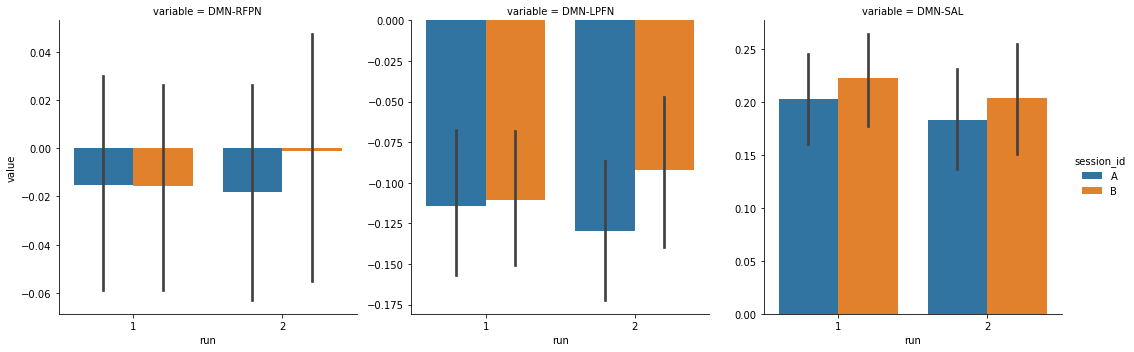

In [71]:
sns.catplot(data=df_long, y='value', hue='session_id', x='run', col='variable', kind = 'bar', sharey=False)
